# 説明可能な AI (XAI)

本章では説明可能な AI （Explanable AI）について触れます。  
具体的には、機械学習の予測結果などを説明する際の一つの方法として、SHAP などについてご紹介します。  
機械学習を用いた取り組みの際には説明責任を問われることが多いため、この周辺知識は習得しておくと良いでしょう。  

**本章の目的**  

* XAI の概念について押さえる  
* SHAP の実装方法とその解釈方法について学ぶ  

**本章で使用するデータ**  

* SHAP モジュールに予め登録されている Adult Gensus Income 

## 説明可能な AI （XAI）とは

※ こちらはスライドにてご紹介します。スライドは別途 PDF にて配布いたします。  

 ## SHAP による局所的・大局的説明

In [3]:
!pip install -q shap
!pip install -q lightgbm
!pip install -q japanize_matplotlib

     |████████████████████████████████| 4.1 MB 25.5 MB/s 


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import japanize_matplotlib
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = 10, 6

import sklearn
import lightgbm as lgb
import shap

In [6]:
shap.__version__, lgb.__version__

('0.41.0', '2.2.3')

## データセットの準備

In [7]:
# データセットの取得
X, y = shap.datasets.adult()

# 説明変数
X.head()

Age  Workclass  Education-Num  Marital Status  Occupation  Relationship  \
0  39.0          7           13.0               4           1             0   
1  50.0          6           13.0               2           4             4   
2  38.0          4            9.0               0           6             0   
3  53.0          4            7.0               2           6             4   
4  28.0          4           13.0               2          10             5   

   Race  Sex  Capital Gain  Capital Loss  Hours per week  Country  
0     4    1        2174.0           0.0            40.0       39  
1     4    1           0.0           0.0            13.0       39  
2     4    1           0.0           0.0            40.0       39  
3     2    1           0.0           0.0            40.0       39  
4     2    0           0.0           0.0            40.0        5

In [8]:
# 目的変数
y

array([False, False, False, ..., False, False,  True])

In [9]:
# データサイズ
X.shape

(32561, 12)

In [10]:
# データ型
X.dtypes

Age               float32
Workclass            int8
Education-Num     float32
Marital Status       int8
Occupation           int8
Relationship        int64
Race                 int8
Sex                  int8
Capital Gain      float32
Capital Loss      float32
Hours per week    float32
Country              int8
dtype: object

In [11]:
# 欠損値の確認
X.isnull().sum()
# X.isna().sum()

Age               0
Workclass         0
Education-Num     0
Marital Status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital Gain      0
Capital Loss      0
Hours per week    0
Country           0
dtype: int64

データのうち、'Workclass' や 'Marital Status' などカテゴリ型として扱うべきデータがありますが、カテゴリ値を今のままエンコードされた整数値 （int8） で扱うと大小関係で比較した学習を行っていまいます。そのためカテゴリ型に指定しておきましょう。

In [12]:
# カテゴリ変数の指定
for col in X.columns:
    if X[col].dtype == np.int8:
        # キャスト
        X[col] = X[col].astype('category')

print(X.dtypes)

Age                float32
Workclass         category
Education-Num      float32
Marital Status    category
Occupation        category
Relationship         int64
Race              category
Sex               category
Capital Gain       float32
Capital Loss       float32
Hours per week     float32
Country           category
dtype: object


In [13]:
# 学習用とテスト用にデータ分割
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=0)
x_train.shape, x_test.shape

((24420, 12), (8141, 12))

## モデルの準備


LightGBM モデルを用いて学習と評価を行います。

LightGBM は「勾配 Boosting 木」と呼ばれる方法の一種であり、予測と目的変数との誤差を最小化するように、複数の決定木を学習していくモデルで、精度が高く出やすいことと、計算速度が速いことで実務や機械学習コンペティションで頻繁に使用されています。

決定木は、説明変数に関する条件分岐を繰り返して目的変数を予測するモデルです。 
本来解釈性の高い機械学習手法ですが、LightGBM はこの決定木を複数使用するため、相対的に解釈性は低くなってしまうことに留意しておきましょう。  

LightGBM の使用方法には Scikit-API と Learning-API という 2 つの API があります。  
今回は Scikit-API から分類モデルを作成する LGBMClassifier を使用します。

## LGBMClassifierの学習とテストスコアの算出

In [14]:
# 学習
model = lgb.LGBMClassifier(random_state=0)
model.fit(x_train, y_train)

LGBMClassifier(random_state=0)

In [15]:
# 予測値の算出
# predict_prob の返り値は（0 の確率, 1 の確率）の2列なので、1 の確率のみ取得
y_pred_prob = model.predict_proba(x_test)[:, 1]
y_pred = model.predict(x_test)

In [16]:
# 予測値の評価
val = sklearn.metrics.roc_auc_score(y_test, y_pred_prob)
print(f'auc-roc score: {val:.2f}')

auc-roc score: 0.93


In [17]:
# 予測結果の混同行列
pd.crosstab(y_test, y_pred)

col_0  False  True
row_0             
False   5764   395
True     666  1316

## SHAP 値


SHAP 値はすべての特徴量について、ひとつずつ特徴量を追加しながら（追加前の特徴量は「欠損」のように扱って）モデルの予測値を計算し、各特徴量の予測値に対する平均的な影響を Shapley 値で表現します。

特徴量の数に応じて計算時間が増加していまいますが、このような計算量の爆発を回避する方法として、特定のモデルに対して　SHAP 値を効率的に計算するアルゴリズムが提案されています。

* 決定木ベースのモデル：TreeExplainer
* 線形モデル：LinearExplainer
* ディープラーニングモデル：DeepExplainer, GradientExplainer

今回はモデルの実運用時に説明を得る状況を想定して、未知のデータを使用します。

In [18]:
# 説明器の準備とSHAP値の算出
explainer = shap.TreeExplainer(model)
sv_test = explainer.shap_values(x_test)[1]

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [19]:
# データセットと同じサイズの行列が取得できる
x_test.shape, sv_test.shape

((8141, 12), (8141, 12))

In [20]:
# SHAP値の確認
print(sv_test[0])

[-0.1455543   0.00427584  0.05878231 -0.53171065 -0.14814232 -0.62871068
  0.03675372 -0.31615836 -0.24700037 -0.03878225  0.40581868  0.02730911]


この行列の (i, j) 成分は、i 個目の予測における j 番目の特徴量の寄与を表しています。元のテストデータの (i, j) 番目には、i 番目の予測対象の j 番目の特徴量の値が入っているのでちょうど対応していることになります。

この値の意味は、「正であれば正方向に、負であれば負方向に予測値を引っ張っている」ということですが値の大きさには注意が必要です。

まず、SHAP 値は予測値そのもではなく、予測値の平均値からのズレを説明しています。分類モデルの場合は予測確率の値ではなく、そのオッズの値に相当するものとして算出されます。

説明器 （explainer） はモデル学習時点での予測値の平均を `expected_value` 属性に保持しています。これは「負と予測する方向への寄与の平均,正と予測する方向への寄与の平均」のタプルになっており、実際に使う際は　2　番目の要素を使えばよいわけです。したがって　SHAP　の一致性より、次の式が成り立つはずです。

expected_value[1]+(SHAP値の総和)=予測値

実際に算出してみましょう。

In [21]:
explainer.expected_value[1] + sv_test[0].sum()

-3.9630925600794287

In [22]:
y_pred_prob[0]

0.01864982555474554

ここでは一致していません。これは分類モデルを使っていることが原因です。（回帰モデルの場合はここが一致します。）

すべての予測対象について計算してプロットしてみます。

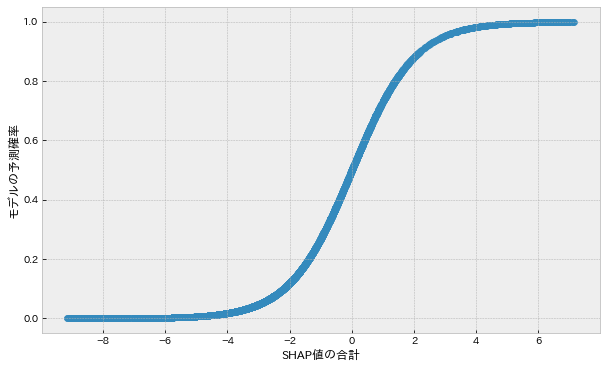

In [23]:
# SHAP値の合計＋平均値
sv_sum = sv_test.sum(axis=1) + explainer.expected_value[1]
plt.scatter(sv_sum, y_pred_prob)
plt.xlabel('SHAP値の合計')
plt.ylabel('モデルの予測確率');

これは次の式で表されるシグモイド関数を表しています。

$$
\rm y = \frac{1}{1+exp(-x)}
$$

分類モデルにおいては、確率値を直接予測するのではなく、実数値（対数オッズ）を予測し、それをシグモイド関数で 0~1 の実数値に変換して、確率の予測値とするのが一般的です。

予測値は確率値である一方で、SHAPの影響度は、モデルが内部で算出している対数オッズをベースにして算出されているため、上記のようなズレが生じていました。

したがって、SHAP 値から元のモデルの確率の予測値を復元したければ、次のように SHAP 値の総和にシグモイド関数を適用させればよいということになります。

### シグモイド関数を適用した SHAP 値の一致性の確認

In [27]:
# SHAP 値から復元したモデルの予測確率
prob_shap = (1/(1+np.exp(-sv_sum)))
prob_shap[0]

0.018649825554745522

In [28]:
# 一致するか確認
assert np.all(np.isclose(prob_shap,y_pred_prob))

ここで一旦まとめます。

モデル -> 予測値（実数オッズ）->（シグモイド関数）-> 予測値（0~1 確率）

↓（平均値を引く）

正規化したオッズ ->（影響度計算）-> SHAP 値

- **ポイント**
    - SHAP 値の総和は予測値の平均からの差分に一致する
    - 分類モデルの場合、SHAP 値は 0~1 の範囲の確率値ではなく、変換前の対数オッズで算出される

## SHAP 値の可視化
上記で、与えたデータと同じサイズ（データ数, 特徴量数）の SHAP 値を得ることができました。  
ここからはこの値を可視化してモデル理解を進めていきます。

### 個別の予測に対する特徴量の影響
1 つの予測に関する情報を得たい場合、得られた行列の 1 行を見ると、各特徴量の影響がわかります。

In [29]:
# javascript を使うために必要
shap.initjs()

# 可視化
#（javascript環境がない場合は matplotlib 引数をTrueにする）
shap.force_plot(explainer.expected_value[1], sv_test[0], x_test.iloc[0])

※ 横軸の値は、確率値に変換する前の値（オッズ）で表示されています。

Relationship や　Hours per week といった特徴量の影響が大きいことがわかります。

特徴量の数が多く可視化した force_plot が見にくくなる場合は、decision_plot という関数をつかいましょう。

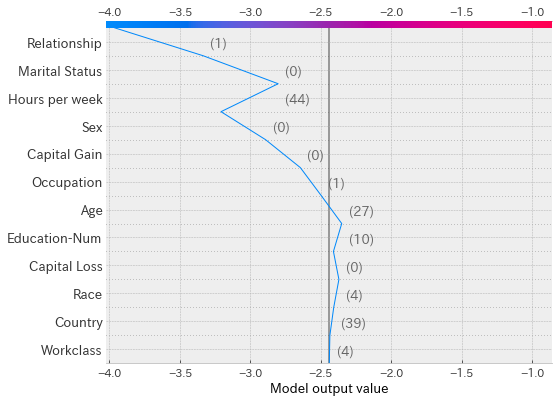

In [30]:
# 特徴量の数が多い場合
shap.initjs()
shap.decision_plot(explainer.expected_value[1], sv_test[0], x_test.iloc[0])

中央最下段を出発点（予測値の平均）として、下から順に特徴量の影響を加えていって、最終的な予測値に至るまでの経路を表示しています。

この例だと半数程度の特徴量はほぼ影響していないことは上位の特徴量がマイナスに効いていることがわかります。

### データセット全体に対する特徴量の効き方
SHAP 自体はモデルの局所的な説明のための技術ですが、すべてのデータに対して 1 件ごとの説明を行い、その全体像を眺めることでモデルの全体的な説明とみなす考え方もあります。

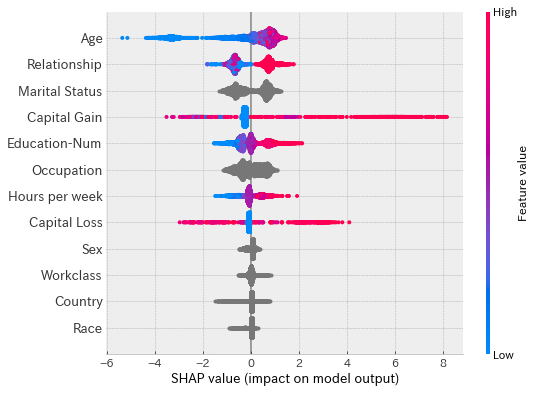

In [ ]:
# データセット全体の特徴量の影響の可視化
shap.summary_plot(sv_test, x_test)

重要度（各予測に対する影響の絶対値の平均値）の順に特徴量が並んでいます。

* 左右の位置：SHAP 値の大きさ
* 色：特徴量の値
* 線の太さ：データの件数


Age だけに着目してみると、

* 年齢が低いとマイナス方向に効き、高いとプラス方向に効いている
* 年齢が高い場合のプラス方向への効き方よりも、年齢が低い場合のマイナス方向への効き方の方が大きい
* 多くの場合、効き方の絶対値は小さく、大きな寄与をするのは一部のケースに限られる

これらのことから、「年齢が低い場合にマイナス方向に予測することがあり、そうでない場合はばらついている」といえそうです。

この例のように、summary_plot を使うとすべての特徴量の効き方の傾向を把握できます。  
SHAP 値から算出される特徴量の重要度のみを知りたい場合は plot_type 引数を指定することで表示できます。

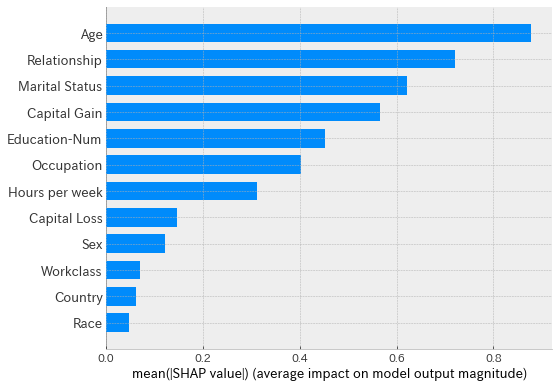

In [ ]:
shap.summary_plot(sv_test, x_test, plot_type='bar')

### 【補足】特徴量の重要度同士の比較

機械学習の分野には特徴量の重要度を算出する方法が多く存在します。

* SHAP 値の絶対値平均
    * 各特徴量の予測値に対する平均的な影響
    * 説明対象：与えたデータに対する予測精度への寄与の大きさ
* 決定木の学習時のゲイン
    * 各特徴量が決定木の分岐においてどの程度用いられたか（その結果、目的関数の値をどの程度下げたか）
    * 説明対象：学習時の loss 関数への寄与の大きさ
    * 未知のデータ（テストデータ）に対する挙動は反映できない
* permutation importance
    * 各特徴量を使わず（その特徴量の値をシャッフルした場合）のテストスコアの変動
    * 説明対象：permutation importance を算出するために用いたデータセットの予測精度への寄与の大きさ

どういった指標を採用すべきかは、説明が求められる文脈で異なることに注意しましょう。

### SHAP 値と特徴量の相関の可視化
1 つの特徴量について細かく確認した場合は　dependence_plot で特徴量の値と　SHAP 値の散布図を確認しましょう。

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


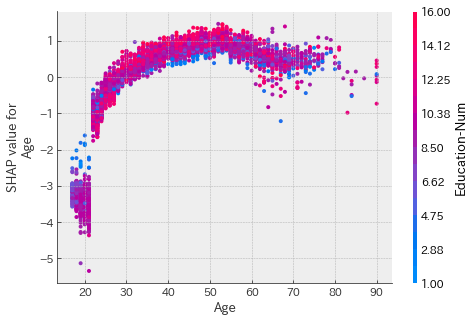

In [ ]:
# Age の影響の散布図
shap.dependence_plot('Age', sv_test, x_test)

横軸に特徴量の値、縦軸にその特徴量の SHAP 値をとっています。

Age が小さいと予測を小さくする方向に働き、一定以上の場合は値によらず同じように（弱くプラス方向に）働く。さらに Age が大きくなるとばらつきが大きくなる

* 年齢が低い場合には、全体的に予測値が低くなるが、例外的にあまり低く効いていないケースがあり、そのような場合には教育水準が高くない
* 年齢が一定以上の場合には、年齢が概ね同じようにプラス方向に影響するが、教育水準が高い場合にはより大きくなり、低い場合には小さくなる（交互作用がある）
* 年齢が 60 歳以上のケースに縦方向のばらつき、特に、予測値が低くなるケースがあるが、その要因はこの図だけでは読み取れない（Educationnum 以外の特徴量との交互作用があると思われる）


といった傾向が読み取れます。

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


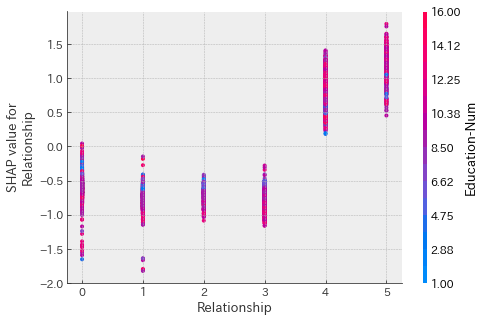

In [ ]:
# Relationship の影響の散布図
shap.dependence_plot('Relationship', sv_test, x_test)

* SHAP 値としては値が　4, 5 の場合にプラス、それ以外ではマイナス方向の寄与を取る傾向がある
* Relationship の値が 2 または 3 のときは、教育水準が大きいときに寄与が小さくなる交互作用がある。値が 4 または 5 のときはやや弱いが、教育水準の値が大きいときに寄与が大きくなる交互作用がある

Age 列に対して他の特徴量との交互作用を見たければ、次のように引数を指定すれば確認できます。

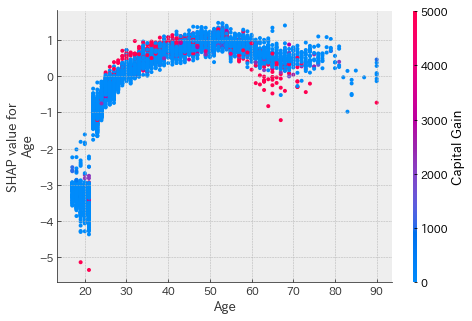

In [ ]:
# Age と Capital Gain の交互作用の散布図
shap.dependence_plot('Age', sv_test, x_test, interaction_index='Capital Gain')

### 変数間の交互作用をより細かく観察する方法


SHAP Interraction Values

* 2 つの特徴量の交互作用のみを取り出して算出する
* 1つの特徴量に対し、全体の効果から他の変数との交互作用を差し引いて、単独の影響のみを算出する

In [ ]:
# SHAP Interaction Value の算出
# iv = explainer.shap_interaction_values(x_test)

# Age と　Capital Gain の交互作用
# shap.dependence_plot(('Age', 'Capotal Gain'), iv, x_test)

# Ageの影響(SHAP値)からそれ以外の特徴量の交互作用を除いたプロット
# shap.dependence_plot(('Age', 'Capotal Gain'), iv, x_test, display_features=x_test)

## SHAP 値の活用


SHAP 値自体は元のデータセットと同じ大きさの実数値行列なので、これを通常のデータ分析の対象と捉えることで、欲しい情報を必要に応じて抽出することが可能になります。

### SHAP 値クラスタリングによるデータの分類

In [ ]:
# SHAP 値の再計算
sv_test = explainer.shap_values(x_test)[1]
shap.initjs()
# 処理が思いのデータ数を絞る
num = 300
shap.force_plot(explainer.expected_value[1], sv_test[:num], x_test[:num])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


このプロットは 1 件のデータに対するプロットを縦方向に回転させ、それを全データについて横方向に並べたものです。  
ここで並び順については似ているデータが近くにくるように設定されています。

このプロットの全体を眺めると、全体の値の正負が一致しているだけでなく、寄与している特徴量が同じもの同士がまとめられていることがわかります。

この force_plot は並び順を返すようには設定できず、プロットを見ただけでは細かい分け方までは確認できません。そこでどうようなめまりにデータがわかれているかをより具体的に確認するためにクラスタリングを行ってみます。

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
model = KMeans(n_clusters=3, random_state=0)
labels = model.fit_predict(sv_test)
# 各クラスに属するデータ数
pd.value_counts(labels)

1    6944
0     828
2     369
dtype: int64

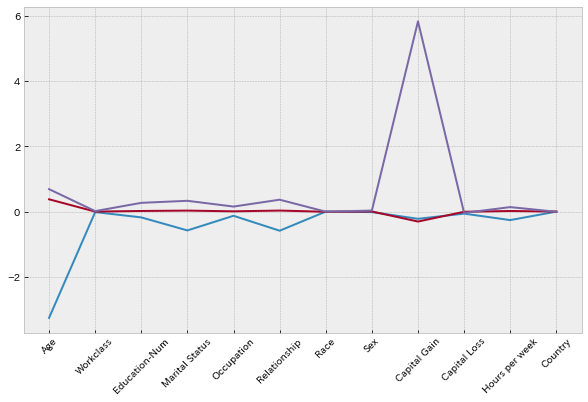

In [ ]:
# クラスタ中心を可視化
center = pd.DataFrame(model.cluster_centers_, columns=X.columns).T
plt.plot(center)
plt.xticks(rotation=45)
plt.show()

この結果を見ると、Capital Gain, Age を基準にしてクラスタリングされていることがわかります。  
これらの特徴量は SHAP 値の影響度でも上位にきていたので、直感的にも妥当な結果であると言えます。

このようなクラスタリングの方法を、原論文では、一般的な教師なしクラスタリングと対比させて supervised clustering と呼んでいます。

モデルの理解という観点では SHAP 値をより単純化して捉えることができ、新しいデータの SHAP 値を計算したときに、どのクラスタに属するかを確認することで、既存のどのデータ群に近い予測が行われているのかを判別できるようなる、といった点が挙げられます。

また、元データにおいて特徴量の単位を揃えるのが難しい場合、精度の良いモデルを使って元データに対するクタスタリングを、SHAP 値クラスタリングで代用する、という活用方法もできます。

SHAP 論文では「このようにして得られたクラスタリングが、既存の他の特徴量影響度の算出手法よりも、よくデータとモデル出力の関係を捉えている」とする実験結果があります。

### 【補足】 次元削減による特徴量の組み合わせ抽出


クラスタリングと近い考え方ですが、SHAP 値行列に対して次元削除を行うと、特徴量の SHAP 値のパターンを抽出できます。そのパターンを確認することで、モデル全体が複数の特徴量をどのように組み合わせて使っているかを、より分かりやすく理解できます。ここでは、 scikitlearn の PCA（主成分分析）モデルを用いて、主成分とそれらの寄与を算出します。

In [ ]:
# 主成分分析の実行と可視化
from sklearn.decomposition import PCA
model = PCA(n_components=4)

In [ ]:
# SHAP値行列の主成分を計算し、係数を返す
sv_trans=model.fit_transform(sv_test)
# 各主成分の寄与(データのばらつきを説明する度合い)
print(model.explained_variance_ratio_)

[0.37508732 0.29738008 0.13824415 0.07299567]


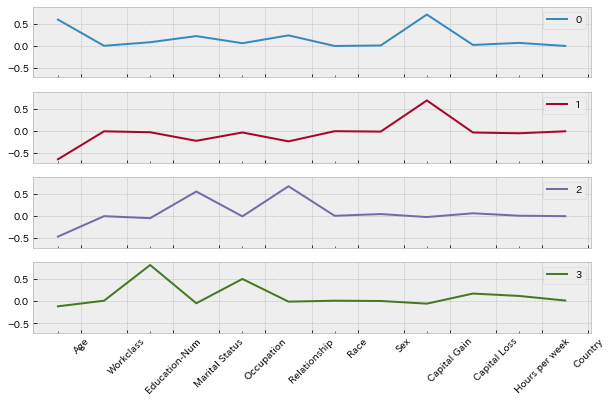

In [ ]:
# 主成分を可視化
comp = pd.DataFrame(model.components_, columns=X.columns).T
comp.plot(subplots=True, sharey=True)
plt.xticks([0.5+ v for v in range(X.shape[1])], labels=X.columns, rotation=45)
plt.show()

プロットの各行がひとつの主成分のベクトル値を示しています。得られた主成分のうち上位3件は、いずれも CapitalGain、Relationship および Age において大きい値をとっています。これは SHAP 値行列がこれらの値の方向に大きく散らばっていることを示しており、SHAP 重要度の結果とも合致します。

今回のケースだと、特徴量の重要度から得られる情報とあまり変わらない結果になりましたが、より特徴量の種類の多いデータにおいては、特徴量のパターンから興味深い情報が得られることもあります。

### 【補足】 類似データの検索と新規性の算出


これまでは主に、元のテストデータ全体におけるモデルの挙動の傾向を分析してきましたが、今度は新しいデータが与えられたときに、以下のような情報を得ることを目指します。

* そのデータに「似ている」元データはどれか（類似データの検索）
* そのデータは元データの集合において、どの程度「珍しい」のか（新規性の算出）

データの内容や使われ方にもよりますが、「類似データ = 過去の具体例」を挙げることで、モデルのユーザがその予測を行う根拠をより直感的に理解できるようになる応用例があります。また、新規性の算出からは、その予測の大まかな信憑性を得ることができます。これは「算出された新規性が小さい」→「モデルは元データと同じような予測をしている」といった考え方によるものです。クラスタリングの項で述べたように、SHAP 値行列では全ての値の単位が揃っているので、これらの値の計算には単純にユークリッド距離を用いることができます。まず、類似データの検索では、新規データに対して単純にユークリッド距離の小さいものを探します

In [ ]:
# モデル学習
model = lgb.LGBMClassifier()
model.fit(x_train, y_train)

LGBMClassifier()

In [ ]:
# テストデータの一部(ここでは末尾100件)を将来予測用に分けて、再度説明器を構築
x_test, x_future = x_test.iloc[: 100], x_test.iloc[100 :]
explainer = shap.TreeExplainer(model)
sv_test = explainer.shap_values(x_test)[1]
sv_future = explainer.shap_values(x_future)[1]

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [ ]:
# テストデータと新規データのユークリッド距離を計算
# dist[i,j]:i番目のテストデータとj番目の新規データのユークリッド距離
N = sv_test.shape[0]
M = sv_future.shape[0]
D = sv_test.shape[1]
distance = np.linalg.norm(sv_test.reshape(N, 1, D) - sv_future.reshape(1, M, D), axis=2)

In [ ]:
# 最も近いデータを取得
near = np.argmin(distance, axis=0)

新規データ:


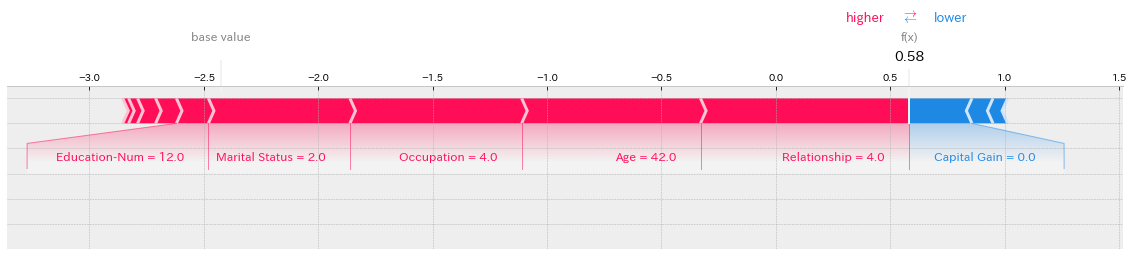

類似データ:


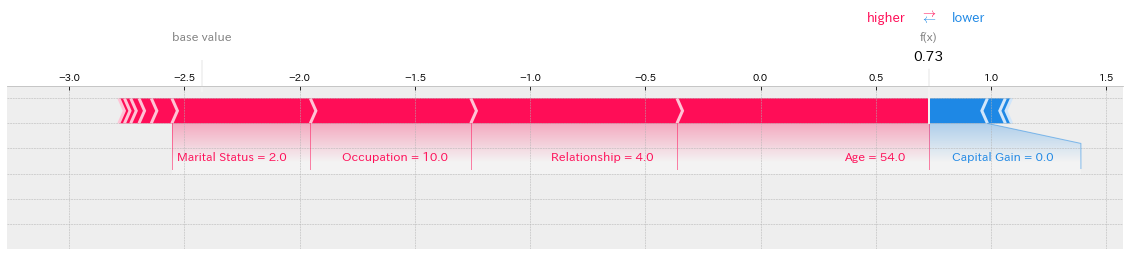

In [ ]:
# 最初の新規データとそれに最も近いテストデータを可視化
i = 0
print('新規データ:')
shap.force_plot(explainer.expected_value[1], sv_future[i], x_future.iloc[i], matplotlib=True)
print('類似データ:')
shap.force_plot(explainer.expected_value[1], sv_test[near[i]], x_test.iloc[near[i]], matplotlib=True)

プロットからは、特徴量の値は一部異なりつつも、SHAP 値の大きさの傾向はかなり似ているデータが得られていることが分かります。最も近いデータのみを抽出しましたが、より多くの情報を得たければ、似ている複数件のデータを抽出したり、抽出する複数件のデータ同士はなるべく異なるものを選ぶ、といった方法を適宜考えることも可能です。

次に、新規性の算出を行います。ここでは「新規性＝異常度」と解釈し、異常検知の手法である「局所外れ値因子法」を適用します。これは新規データに対し、周辺の密度と、新規データの近傍の点の周辺の密度とを比較して、異常度の指標値を算出します。以下ではscikitlearn の実装を用いて異常度を算出します。

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

In [ ]:
model = LocalOutlierFactor(n_neighbors=20, novelty=True)
model.fit(sv_test)
score = model.score_samples(sv_future)
# score:異常度のマイナス1倍.小さいほど異常(=新規性が高い)
print(score[:5])

[-0.97791521 -1.49314062 -1.50114886 -1.02164163 -1.05324144]


In [ ]:
# 最も新規性が大きい1件を取り出し可視化
index = np.argmin(score)
print('新規データ')
shap.force_plot(explainer.expected_value[1], sv_future[index], x_future.iloc[index], matplotlib=True)

新規データ


得られたスコアは、データ点の周辺の密度とその近傍点の密度の比の逆数のマイナス 1 倍になっており、これが 1 を有意に下回れば「異常である」とみなすことができます。